# A minimal example of how to use Kruskal Test and analysis the Posh-hoc test result

In [1]:
%matplotlib inline

# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from roses.statistical_test.kruskal_wallis import kruskal_wallis
from roses.effect_size import vargha_delaney

# rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# For a beautiful plot
plt.style.use('ggplot')

# If you want let the plot beautiful
import seaborn as sns
sns.set_style("whitegrid")
sns.set(palette="pastel")

# Improving the readability in the plots
FONT_SIZE_PLOTS = 16
plt.rcParams.update({
    'font.size': FONT_SIZE_PLOTS,
    'xtick.labelsize': FONT_SIZE_PLOTS,
    'ytick.labelsize': FONT_SIZE_PLOTS,
    'legend.fontsize': FONT_SIZE_PLOTS,
    'axes.titlesize' : FONT_SIZE_PLOTS,
    'axes.labelsize' : FONT_SIZE_PLOTS
})

## Function to help the analysis

In [2]:
def print_mean(df):
    """
    This function group the data and presents for each algorithm the mean, std, max, and min values.
    Besides that, it returns the best algorithm based on the maximum mean value.
    """
    mean = df.groupby(['algorithm'], as_index=False).agg({'fitness': ['mean', 'std', 'max', 'min']})
    mean.columns = ['name', 'mean', 'std', 'max', 'min']
    
    # Round values (to be used in the article)
    mean = mean.round({'mean': 4, 'std': 3, 'max': 4, 'min': 4})
    mean = mean.infer_objects()

    bestalg = mean.loc[mean['mean'].idxmax()]

    return mean, bestalg['name']

## Read the Data

In [3]:
df = pd.read_csv('../resources/kruskal.csv', sep=";")
df

,algorithm,fitness
0,AlgorithmA,0.778856
1,AlgorithmD,0.730263
2,AlgorithmE,0.664486
3,AlgorithmB,0.742775
4,AlgorithmC,0.730346
...,...,...
145,AlgorithmA,0.780547
146,AlgorithmD,0.732662
147,AlgorithmE,0.671618
148,AlgorithmB,0.742228


## Apply the Kruskal-Wallis Test in the data

R[write to console]: Loading required package: PMCMRplus

R[write to console]: Loading required package: devtools

R[write to console]: Loading required package: usethis

R[write to console]: Loading required package: scmamp

R[write to console]: 
Attaching package: ‘scmamp’


R[write to console]: The following objects are masked from ‘package:PMCMRplus’:

    friedmanTest, tukeyTest




,Source,ddof1,H,p-unc
Kruskal,algorithm,4,135.950552,2.076855e-28


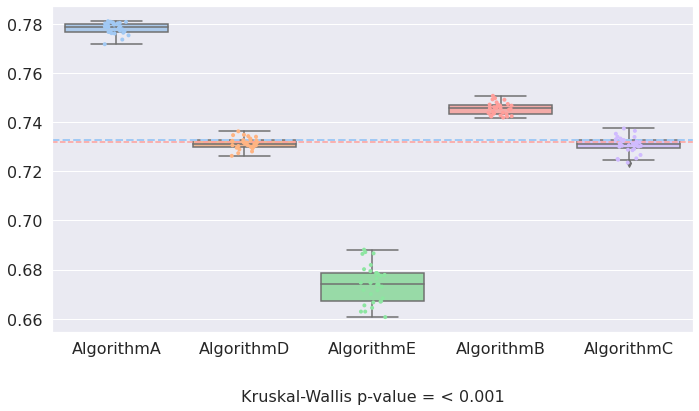

In [4]:
fig, ax = plt.subplots(figsize=(10,6))

k = kruskal_wallis(df, 'fitness', 'algorithm')
kruskal_result, posthoc = k.apply(ax)
plt.tight_layout()

kruskal_result

#plt.savefig("kruskal.pdf", bbox_inches='tight')
#plt.cla()
#plt.close(fig)

## Identifying the best algorithm

In [5]:
mean, best = print_mean(df)

print("Best algorithm:", best, "\n\nMeans:")

mean

Best algorithm: AlgorithmA 

Means:


,name,mean,std,max,min
0,AlgorithmA,0.7782,0.002,0.7810,0.7717
1,AlgorithmB,0.7455,0.002,0.7507,0.7419
2,AlgorithmC,0.7307,0.003,0.7374,0.7235
3,AlgorithmD,0.7313,0.002,0.7363,0.7263
4,AlgorithmE,0.6742,0.008,0.6881,0.6607


## Post-Hoc Tests

In [6]:
# post-hoc p-value results (if posthoc is not None)
print(posthoc[0])

R[write to console]: 
	Pairwise comparisons using Tukey-Kramer-Nemenyi all-pairs test with Tukey-Dist approximation


R[write to console]: data: value and group


R[write to console]: 
P value adjustment method: single-step

R[write to console]: alternative hypothesis: two.sided



           AlgorithmA AlgorithmB AlgorithmC AlgorithmD
AlgorithmB 0.05780    -          -          -         
AlgorithmC 1.0e-10    0.00035    -          -         
AlgorithmD 5.1e-10    0.00094    0.99930    -         
AlgorithmE 4.7e-14    7.6e-14    0.00094    0.00035   



In [7]:
# Get the posthoc and prepare the comparison against the best algorithm
df_eff = vargha_delaney.reduce(posthoc[1], best)

# Define symbols for each effect size magnitude
mean['eff_symbol'] = " "

def get_eff_symbol(x, best, df_eff):
    if x['name'] == best:
        return "$\\bigstar$"
    elif len(df_eff.loc[df_eff.compared_with == x['name'], 'effect_size_symbol'].values) > 0:
        return df_eff.loc[df_eff.compared_with == x['name'], 'effect_size_symbol'].values[0]
    else:
        return df_eff.loc[df_eff.base == x['name'], 'effect_size_symbol'].values[0]

mean['eff_symbol'] = mean.apply(lambda x: get_eff_symbol(x, best, df_eff), axis=1)

# Concat the values to a unique columns
mean['avg_std_effect'] = mean.apply(lambda row: f"{row['mean']:.4f} $\\pm$ {row['std']:.4f} {row['eff_symbol']}", axis=1)

# Select the main information
mean = mean[['name', 'avg_std_effect']]

In [8]:
mean

,name,avg_std_effect
0,AlgorithmA,0.7782 $\pm$ 0.0020 $\bigstar$
1,AlgorithmB,0.7455 $\pm$ 0.0020 $\blacktriangle$
2,AlgorithmC,0.7307 $\pm$ 0.0030 $\blacktriangle$
3,AlgorithmD,0.7313 $\pm$ 0.0020 $\blacktriangle$
4,AlgorithmE,0.6742 $\pm$ 0.0080 $\blacktriangle$


### Display the AVG +- STD EFFECT_SIZE and symbols for each effect size magnitude

In [9]:
mean_trans = mean.copy()
mean_trans.index = mean['name']
mean_trans = mean_trans.transpose()

temp_x = mean_trans.to_string(index=False, index_names=False).split("\n")[1:]
print(temp_x[0]) # Column names

# Just a beautiful print to use with LaTeX table :}
temp_split = temp_x[1].split()
cont = 1
for x in temp_split:
    print(f"{x} ", end="")
    if (cont % 4 == 0 and cont != len(temp_split)):
        print("& ", end="")
    cont += 1
print("\n\n")

                    AlgorithmA                           AlgorithmB                           AlgorithmC                           AlgorithmD                           AlgorithmE
0.7782 $\pm$ 0.0020 $\bigstar$ & 0.7455 $\pm$ 0.0020 $\blacktriangle$ & 0.7307 $\pm$ 0.0030 $\blacktriangle$ & 0.7313 $\pm$ 0.0020 $\blacktriangle$ & 0.6742 $\pm$ 0.0080 $\blacktriangle$ 




## Convert the posthoc to a DataFrame in pandas (workaround)

In [10]:
ro.r.assign('posthoc', posthoc[0])
ro.r('posthoc_table <- t(as.matrix(posthoc$p.value))')
ro.r('df_posthoc <- as.data.frame(t(posthoc_table))')

with localconverter(ro.default_converter + pandas2ri.converter):
    posthoc_df = ro.conversion.rpy2py(ro.r('df_posthoc'))

## Now, we gonna to check each posthoc value to color the cells: best in bold and equivalent to the best one in gray

In [12]:
def get_config_latex(row, best, posthoc_df):
    """
    Latex commands used:
    - Best algorithm: \newcommand{\cellgray}[1]{\cellcolor{gray!30}{#1}}
    - Equivalent to the best one: \newcommand{\cellbold}[1]{\cellcolor{gray!30}{\textbf{#1}}}
    """
    current_name =  row['name']
    is_equivalent = False
    
    if best in posthoc_df.columns and current_name in posthoc_df.index and not np.isnan(posthoc_df.loc[current_name][best]):
        # They are equivalent
        is_equivalent = posthoc_df.loc[current_name][best] >= 0.05                    
    elif current_name in posthoc_df.columns and best in posthoc_df.index and not np.isnan(posthoc_df.loc[best][current_name]):
        # They are equivalent
        is_equivalent = posthoc_df.loc[current_name][best] >= 0.05             
        
    if is_equivalent:
        return f"\\cellgray{{{row['avg_std_effect']}}}"
    elif row['name'] == best:
        return f"\\cellbold{{{row['avg_std_effect']}}}"
    else:
        return row['avg_std_effect'] 
                
mean['latex_format'] = mean.apply(lambda row: get_config_latex(row, best, posthoc_df), axis=1)

## Display the new latex format

In [13]:
# Select the main information
mean = mean[['name', 'latex_format']]

mean_trans = mean.copy()
mean_trans.index = mean['name']
mean_trans = mean_trans.transpose()

temp_x = mean_trans.to_string(index=False, index_names=False).split("\n")[1:]
print(temp_x[0]) # Column names

# Just a beautiful print to use with LaTeX table :}
temp_split = temp_x[1].split()
cont = 1
for x in temp_split:
    print(f"{x} ", end="")
    if (cont % 4 == 0 and cont != len(temp_split)):
        print("& ", end="")
    cont += 1
print("\n\n")

                               AlgorithmA                                      AlgorithmB                           AlgorithmC                           AlgorithmD                           AlgorithmE
\cellbold{0.7782 $\pm$ 0.0020 $\bigstar$} & \cellgray{0.7455 $\pm$ 0.0020 $\blacktriangle$} & 0.7307 $\pm$ 0.0030 $\blacktriangle$ & 0.7313 $\pm$ 0.0020 $\blacktriangle$ & 0.6742 $\pm$ 0.0080 $\blacktriangle$ 


